## General Workflow

### 1) Identifying Business Problem
### 2) Data Preprocessing
### 3) Exploratory Data Analysis (EDA)

### 1) Identifying Business Problem

In this case, we're asked to develop a model for an organization that helps non-profit organizations to find donors. This model will be used to predict whether a donor will spend more than or equal to 30€, given that this donor receives a re-activation campaign. The model will be trained based on the previous campaign, and then validated with another data from other campaign.

The model is expected to have a good performance and high interpretability. In addition, we also have to emphasize why does implementing the model is better than random guessing campaign. In the end, the model will be used to predict potential customers for the upcoming campaign, and which customers are the most effective to reach.

### 2) Data Preprocessing

Our data consist of 5 csv files which includes the donor database, the amount of donated, and the selected donors during previous campaign

In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
# Drop 1st Column
donors=pd.read_csv("./data/donors.csv")

donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

donors['province'] = donors['province'].apply(lambda row: 'Antwerp' if row == 'ANTWERP' else row)

gender_dict={'F':1,'M':0,'NaN':969}
language_dict={'EN':1,'FR':2,'NL':3}
region_dict={'Brussels':1,'Flanders':2,'Missing':3,'Wallonia':4}
province_dict={'Antwerp':1,'Brussels':2,'East Flanders':3,'Flemish Brabant':4,
                'Hainaut':5,'Liege':6,'Limburg':7,'Luxembourg':8,'Missing':9,
                'Namur':10,'Walloon Brabant':11,'West Flanders':12}


donors = donors.replace({"province": province_dict, "region": region_dict, "gender": gender_dict,"language":language_dict})

donors.head()

,Unnamed: 0,donorID,zipcode,province,region,gender,language,dateOfBirth
0,0,100001,1861.0,4,2,1.0,3,1967-12-24
1,1,100002,2260.0,1,2,0.0,3,1952-01-14
2,2,100003,1780.0,4,2,0.0,3,1986-12-23
3,3,100004,1020.0,2,1,1.0,2,1952-03-29
4,4,100005,1020.0,2,1,1.0,2,1986-06-25


In [3]:
campaigns=pd.read_csv("./Data/campaigns.csv",delimiter=";")

for i in range(0,len(campaigns)):
    campaigns.iloc[i,2]=campaigns.iloc[i,2].replace('\u202f','')

for i in range(0,len(campaigns)):
    campaigns.iloc[i,3]=campaigns.iloc[i,3].replace('\xa0€','')

for i in range(0,len(campaigns)):
    campaigns.iloc[i,3]=campaigns.iloc[i,3].replace(',','.')

campaigns['date']=pd.to_datetime(campaigns['date'])
campaigns['lettersSent']=campaigns['lettersSent'].astype(int)
campaigns['lettersSent']=campaigns['lettersSent'].astype(float)
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6873.0,0.17
1,154,2005-01-01,7656.0,0.30
2,180,2005-01-18,9933.0,0.20
3,433,2005-01-29,7448.0,0.59
4,476,2005-12-02,6605.0,0.51


In [4]:
gifts=pd.read_csv("./Data/gifts.csv")
#cleaning gift
# Change date into datetime object
gifts['date'] = pd.to_datetime(gifts['date'])
#
gifts['amount'] = gifts['amount'].str.replace(',', '.')
#
gifts['amount'] = gifts['amount'].astype('float')
#
gifts.head()

,Unnamed: 0,donorID,campaignID,amount,date
0,0,100001,NaN,12.39,2004-03-23
1,1,100001,1577.0,12.39,2007-10-11
2,2,100001,1634.0,6.69,2007-12-28
3,3,100001,1778.0,24.79,2008-06-14
4,4,100001,1808.0,7.44,2008-07-09


In [5]:
#
def agg_A(tr):
    tr['total_donated_during_dv'] = tr['amount'].sum()
    return tr
#
gift_6169=gifts[gifts['campaignID'] == 6169]
#
gift_6169 = gift_6169.groupby(by='donorID').apply(agg_A)
#
gift_6169=gift_6169.drop(['campaignID','Unnamed: 0','amount','date'],axis=1)
#
gift_6169.head()

,donorID,total_donated_during_dv
132,100023,15.0
705,100126,123.0
1151,100253,120.0
1362,100279,75.0
1804,100320,135.0


In [6]:
#
gift_7244=gifts[gifts['campaignID'] == 7244]
#
gift_7244 = gift_7244.groupby(by='donorID').apply(agg_A)
#
gift_7244=gift_7244.drop(['campaignID','Unnamed: 0','amount','date'],axis=1)
#
gift_7244.head()

,donorID,total_donated_during_dv
5828,100724,40.0
7527,100896,10.0
8314,100964,100.0
9269,101066,60.0
9316,101069,80.0


In [7]:
selection_6169=pd.read_csv("./Data/selection campaign 6169.csv")
selection_7244=pd.read_csv("./Data/selection campaign 7244.csv")
selection_7362=pd.read_csv("./Data/new_campaign_selection.csv")

In [8]:
#duration of data gadering
iv_period = 180
# dayes befor starting the data gadering
in_between_period = 30
# start and end dates of campaign 6169
date_campaign_6169 = datetime.datetime(2018, 9, 4)
end_period_6169 = date_campaign_6169 - datetime.timedelta(days = in_between_period)
start_period_6169 = end_period_6169 - datetime.timedelta(days = iv_period)
# start and end dates of campaign 7244
date_campaign_7244 = datetime.datetime(2019, 6, 18)
end_period_7244 = date_campaign_7244 - datetime.timedelta(days = in_between_period)
start_period_7244 = end_period_7244 - datetime.timedelta(days = iv_period)
# start and end dates of campaign 7362
date_campaign_7362 = datetime.datetime(2020, 2, 1)
end_period_7362 = date_campaign_7362 - datetime.timedelta(days = in_between_period)
start_period_7362 = end_period_7362 - datetime.timedelta(days = iv_period)


## 6169 Base Table

# Aggregate Data

In [9]:
def agg_Till(tr):
    
    tr['total_freq_till_now'] = tr['amount'].count()
    tr['total_amount_till_now'] = tr['amount'].sum()
    date=start_period_6169
    Last3_years = tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*365))]
    tr['total_amount_till_last_3_years'] = Last3_years['amount'].sum()
    tr['total_freq_till_last_3_years'] = Last3_years['amount'].count()

    tr = tr.drop(['date','amount','Unnamed: 0','campaignID'],axis=1)
    return tr

gift_till_6169=gifts[gifts['date'] <= start_period_6169]

gift_till_6169 = gift_till_6169.groupby(by='donorID').apply(agg_Till)

gift_till_6169.head()

gift_till_6169 = gift_till_6169.drop_duplicates()

In [10]:
def agg_Till(tr):
    
    tr['total_freq_till_now'] = tr['amount'].count()
    tr['total_amount_till_now'] = tr['amount'].sum()
    date=start_period_7244
    Last3_years = tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*365))]
    tr['total_amount_till_last_3_years'] = Last3_years['amount'].sum()
    tr['total_freq_till_last_3_years'] = Last3_years['amount'].count()

    tr = tr.drop(['date','amount','Unnamed: 0','campaignID'],axis=1)
    return tr

gift_till_7244=gifts[gifts['date'] <= start_period_7244]

gift_till_7244 = gift_till_7244.groupby(by='donorID').apply(agg_Till)

gift_till_7244 = gift_till_7244.drop_duplicates()

In [11]:
def agg_Till(tr):
    
    tr['total_freq_till_now'] = tr['amount'].count()
    tr['total_amount_till_now'] = tr['amount'].sum()
    date=start_period_7362
    Last3_years = tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*365))]
    tr['total_amount_till_last_3_years'] = Last3_years['amount'].sum()
    tr['total_freq_till_last_3_years'] = Last3_years['amount'].count()

    tr = tr.drop(['date','amount','Unnamed: 0','campaignID'],axis=1)
    return tr

gift_till_7362=gifts[gifts['date'] <= start_period_7362]

gift_till_7362 = gift_till_7362.groupby(by='donorID').apply(agg_Till)

gift_till_7362 = gift_till_7362.drop_duplicates()

In [12]:
#
def agg_B(tr):
    tr['last_date_dono'] = tr['date'].max()
    tr['frequency_donor'] = tr['amount'].count()
    tr['total_donated'] = tr['amount'].sum()
    c_5434 = tr.loc[(tr['campaignID'] == 5434)]
    tr['C1'] = c_5434['amount'].sum()

    c_5397 = tr.loc[(tr['campaignID'] == 5397)]
    tr['C2'] = c_5397['amount'].sum()

    c_5359 = tr.loc[(tr['campaignID'] == 5359)]
    tr['C3'] = c_5359['amount'].sum()

    c_5326 = tr.loc[(tr['campaignID'] == 5326)]
    tr['C4'] = c_5326['amount'].sum()

    c_5316 = tr.loc[(tr['campaignID'] == 5316)]
    tr['C5'] = c_5316['amount'].sum()

    c_5296 = tr.loc[(tr['campaignID'] == 5296)]
    tr['C6'] = c_5296['amount'].sum()

    c_5270 = tr.loc[(tr['campaignID'] == 5270)]
    tr['C7'] = c_5270['amount'].sum()

    c_5267 = tr.loc[(tr['campaignID'] == 5267)]
    tr['C8'] = c_5267['amount'].sum()

    c_5232 = tr.loc[(tr['campaignID'] == 5232)]
    tr['C9'] = c_5232['amount'].sum()

    c_5213 = tr.loc[(tr['campaignID'] == 5213)]
    tr['C10'] = c_5213['amount'].sum()

    c_5186 = tr.loc[(tr['campaignID'] == 5186)]
    tr['C11'] = c_5186['amount'].sum()

    c_5175 = tr.loc[(tr['campaignID'] == 5175)]
    tr['C12'] = c_5175['amount'].sum()

    c_5104 = tr.loc[(tr['campaignID'] == 5104)]
    tr['C13'] = c_5104['amount'].sum()
    date=start_period_6169
    month_1= tr.loc[(tr['date'] > date- datetime.timedelta(days = 30))]
    tr['total_amount_1_month'] = month_1['amount'].sum()
    tr['total_freq_1_month'] = month_1['amount'].count()
    month_2= tr.loc[(tr['date'] > date- datetime.timedelta(days = 2*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 30))]
    tr['total_amount_2_month'] = month_2['amount'].sum()
    tr['total_freq_2_month'] = month_2['amount'].count()
    month_3= tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 2*30))]
    tr['total_amount_3_month'] = month_3['amount'].sum()
    tr['total_freq_3_month'] = month_3['amount'].count()
    month_4= tr.loc[(tr['date'] > date- datetime.timedelta(days = 4*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 3*30))]
    tr['total_amount_4_month'] = month_4['amount'].sum()
    tr['total_freq_4_month'] = month_4['amount'].count()
    month_5= tr.loc[(tr['date'] > date- datetime.timedelta(days = 5*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 4*30))]
    tr['total_amount_5_month'] = month_5['amount'].sum()
    tr['total_freq_5_month'] = month_5['amount'].count()
    month_6= tr.loc[(tr['date'] > date- datetime.timedelta(days = 6*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 5*30))]
    tr['total_amount_6_month'] = month_6['amount'].sum()
    tr['total_freq_6_month'] = month_6['amount'].count()
    
    tr = tr.drop(['date','amount','Unnamed: 0'],axis=1)
    return tr
#
gift_base_6169 = gifts[(gifts['date'] >= start_period_6169) &  (gifts['date'] <= end_period_6169)]
#
gift_base_6169 = gift_base_6169.groupby(by='donorID').apply(agg_B)
# remove duplicate rows
gift_base_6169 = gift_base_6169.drop_duplicates(subset=['donorID'])
#
gift_base_6169['Recency_dono'] = end_period_6169 - gift_base_6169['last_date_dono']
#
gift_base_6169['Recency_dono'] = gift_base_6169['Recency_dono'].dt.days
#
gift_base_6169=gift_base_6169.drop(['last_date_dono'],axis=1)
# Build Base Table Based On the 6169 Campaign Data
gift_base_6169 = pd.merge(selection_6169,gift_base_6169, how='left', on='donorID')
# Merge with dv table
gift_base_6169 = pd.merge(gift_base_6169, gift_6169, how='left', on='donorID')
# Merge with donor database
gift_base_6169 = pd.merge(gift_base_6169, donors, how='left', on='donorID')
#_______Hadi added this merge_ U can check it guys :)
#gift_base_6169 = pd.merge(gift_base_6169, gift_till_6169, how='left', on='donorID')
#________________________________________
# Target Variable
gift_base_6169['donated_more_than30_duringdv'] = gift_base_6169['total_donated_during_dv'].apply(
                                                                lambda row: 1 if row >= 30 else 0)
#
gift_base_6169['Age'] = gift_base_6169['dateOfBirth'].apply(lambda row:
                 date_campaign_6169.year - row.year -((date_campaign_6169.month, date_campaign_6169.day) < (row.month, row.day) ))
#
gift_base_6169=gift_base_6169.drop(['Unnamed: 0','total_donated_during_dv','dateOfBirth'],axis=1)
#filling nans
gift_base_6169['total_donated'] = gift_base_6169['total_donated'].fillna(0)#gift_base_6169['total_donated'].mean())
gift_base_6169['Recency_dono'] = gift_base_6169['Recency_dono'].fillna(0)#gift_base_6169['Recency_dono'].mean())
gift_base_6169['frequency_donor'] = gift_base_6169['frequency_donor'].fillna(0)#gift_base_6169['frequency_donor'].median())
#save base tabel 6169 
gift_base_6169.to_csv('./data/gift_base_6169.csv')
#showing Data
gift_base_6169.head()

,donorID,campaignID,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,...,total_amount_6_month,total_freq_6_month,Recency_dono,zipcode,province,region,gender,language,donated_more_than30_duringdv,Age
0,100001,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1861.0,4.0,2.0,1.0,3.0,0,50.0
1,100002,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2260.0,1.0,2.0,0.0,3.0,0,66.0
2,100004,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1020.0,2.0,1.0,1.0,2.0,0,66.0
3,100008,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1780.0,4.0,2.0,0.0,2.0,0,81.0
4,100009,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1020.0,2.0,1.0,0.0,2.0,0,86.0


In [13]:
#
def agg_B(tr):
    tr['last_date_dono'] = tr['date'].max()
    tr['frequency_donor'] = tr['amount'].count()
    tr['total_donated'] = tr['amount'].sum()
    c_7229 = tr.loc[(tr['campaignID'] == 7229)]
    tr['C1'] = c_7229['amount'].sum()

    c_7212 = tr.loc[(tr['campaignID'] == 7212)]
    tr['C2'] = c_7212['amount'].sum()

    c_7199 = tr.loc[(tr['campaignID'] == 7199)]
    tr['C3'] = c_7199['amount'].sum()

    c_7108 = tr.loc[(tr['campaignID'] == 7108)]
    tr['C4'] = c_7108['amount'].sum()

    c_7090 = tr.loc[(tr['campaignID'] == 7090)]
    tr['C5'] = c_7090['amount'].sum()

    c_7074 = tr.loc[(tr['campaignID'] == 7074)]
    tr['C6'] = c_7074['amount'].sum()

    c_7064 = tr.loc[(tr['campaignID'] == 7064)]
    tr['C7'] = c_7064['amount'].sum()

    c_7059 = tr.loc[(tr['campaignID'] == 7059)]
    tr['C8'] = c_7059['amount'].sum()

    c_7037 = tr.loc[(tr['campaignID'] == 7037)]
    tr['C9'] = c_7037['amount'].sum()

    c_7005 = tr.loc[(tr['campaignID'] == 7005)]
    tr['C10'] = c_7005['amount'].sum()

    c_7002 = tr.loc[(tr['campaignID'] == 7002)]
    tr['C11'] = c_7002['amount'].sum()

    c_6959 = tr.loc[(tr['campaignID'] == 6959)]
    tr['C12'] = c_6959['amount'].sum()

    c_6958 = tr.loc[(tr['campaignID'] == 6958)]
    tr['C13'] = c_6958['amount'].sum()

    date=start_period_7244
    month_1= tr.loc[(tr['date'] > date- datetime.timedelta(days = 30))]
    tr['total_amount_1_month'] = month_1['amount'].sum()
    tr['total_freq_1_month'] = month_1['amount'].count()
    month_2= tr.loc[(tr['date'] > date- datetime.timedelta(days = 2*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 30))]
    tr['total_amount_2_month'] = month_2['amount'].sum()
    tr['total_freq_2_month'] = month_2['amount'].count()
    month_3= tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 2*30))]
    tr['total_amount_3_month'] = month_3['amount'].sum()
    tr['total_freq_3_month'] = month_3['amount'].count()
    month_4= tr.loc[(tr['date'] > date- datetime.timedelta(days = 4*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 3*30))]
    tr['total_amount_4_month'] = month_4['amount'].sum()
    tr['total_freq_4_month'] = month_4['amount'].count()
    month_5= tr.loc[(tr['date'] > date- datetime.timedelta(days = 5*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 4*30))]
    tr['total_amount_5_month'] = month_5['amount'].sum()
    tr['total_freq_5_month'] = month_5['amount'].count()
    month_6= tr.loc[(tr['date'] > date- datetime.timedelta(days = 6*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 5*30))]
    tr['total_amount_6_month'] = month_6['amount'].sum()
    tr['total_freq_6_month'] = month_6['amount'].count()
    
    tr = tr.drop(['date','amount','Unnamed: 0'],axis=1)
    return tr
gift_base_7244 = gifts[(gifts['date'] >= start_period_7244) &  (gifts['date'] <= end_period_7244)]
#
gift_base_7244=gift_base_7244.groupby(by='donorID').apply(agg_B)
# remove duplicate rows
gift_base_7244 = gift_base_7244.drop_duplicates(subset=['donorID'])
#
gift_base_7244['Recency_dono'] = end_period_7244 - gift_base_7244['last_date_dono']
#
gift_base_7244['Recency_dono'] = gift_base_7244['Recency_dono'].dt.days
#
gift_base_7244=gift_base_7244.drop(['last_date_dono'],axis=1)
# Build Base Table Based On the 7244 Campaign Data
gift_base_7244 = pd.merge(selection_7244,gift_base_7244, how='left', on='donorID')
# # Merge with iv table
gift_base_7244 = pd.merge(gift_base_7244, gift_7244, how='left', on='donorID')
# Merge with donor database
gift_base_7244 = pd.merge(gift_base_7244, donors, how='left', on='donorID')
#_______Hadi added this merge_ U can check it guys :)
#gift_base_7244 = pd.merge(gift_base_7244, gift_till_7244, how='left', on='donorID')
#________________________________________
# Target Variable
gift_base_7244['donated_more_than30_duringdv'] = gift_base_7244['total_donated_during_dv'].apply(
                                                                lambda row: 1 if row >= 30 else 0)
#
gift_base_7244['Age'] = gift_base_7244['dateOfBirth'].apply(lambda row:
                 date_campaign_7244.year - row.year -((date_campaign_7244.month, date_campaign_7244.day) < (row.month, row.day) ))
#
gift_base_7244=gift_base_7244.drop(['Unnamed: 0','total_donated_during_dv','dateOfBirth'],axis=1)
#filling nans
gift_base_7244['total_donated'] = gift_base_7244['total_donated'].fillna(0)#gift_base_7244['total_donated'].mean())
gift_base_7244['Recency_dono'] = gift_base_7244['Recency_dono'].fillna(0)#gift_base_7244['Recency_dono'].mean())
gift_base_7244['frequency_donor'] = gift_base_7244['frequency_donor'].fillna(0)#gift_base_7244['frequency_donor'].median())
#save base tabel 7244
gift_base_7244.to_csv('./data/gift_base_7244.csv')
#showing Data
gift_base_7244.head()

,donorID,campaignID,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,...,total_amount_6_month,total_freq_6_month,Recency_dono,zipcode,province,region,gender,language,donated_more_than30_duringdv,Age
0,100001,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1861.0,4,2,1.0,3,0,51
1,100002,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2260.0,1,2,0.0,3,0,67
2,100008,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1780.0,4,2,0.0,2,0,81
3,100009,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1020.0,2,1,0.0,2,0,87
4,100010,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1020.0,2,1,0.0,2,0,36


In [14]:
#
def agg_B(tr):
    tr['last_date_dono'] = tr['date'].max()
    tr['frequency_donor'] = tr['amount'].count()
    tr['total_donated'] = tr['amount'].sum()
    c_7536 = tr.loc[(tr['campaignID'] == 7536)]
    tr['C1'] = c_7536['amount'].sum()

    c_7519 = tr.loc[(tr['campaignID'] == 7519)]
    tr['C2'] = c_7519['amount'].sum()

    c_7505 = tr.loc[(tr['campaignID'] == 7505)]
    tr['C3'] = c_7505['amount'].sum()

    c_7503 = tr.loc[(tr['campaignID'] == 7503)]
    tr['C4'] = c_7503['amount'].sum()

    c_7494 = tr.loc[(tr['campaignID'] == 7494)]
    tr['C5'] = c_7494['amount'].sum()

    c_7408 = tr.loc[(tr['campaignID'] == 7408)]
    tr['C6'] = c_7408['amount'].sum()

    c_7395 = tr.loc[(tr['campaignID'] == 7395)]
    tr['C7'] = c_7395['amount'].sum()

    c_7356 = tr.loc[(tr['campaignID'] == 7356)]
    tr['C8'] = c_7356['amount'].sum()

    c_7346 = tr.loc[(tr['campaignID'] == 7346)]
    tr['C9'] = c_7346['amount'].sum()

    c_7335 = tr.loc[(tr['campaignID'] == 7335)]
    tr['C10'] = c_7335['amount'].sum()

    c_7330 = tr.loc[(tr['campaignID'] == 7330)]
    tr['C11'] = c_7330['amount'].sum()

    c_7276 = tr.loc[(tr['campaignID'] == 7276)]
    tr['C12'] = c_7276['amount'].sum()

    c_7244 = tr.loc[(tr['campaignID'] == 7244)]
    tr['C13'] = c_7244['amount'].sum()

    date=start_period_7362
    month_1= tr.loc[(tr['date'] > date- datetime.timedelta(days = 30))]
    tr['total_amount_1_month'] = month_1['amount'].sum()
    tr['total_freq_1_month'] = month_1['amount'].count()
    month_2= tr.loc[(tr['date'] > date- datetime.timedelta(days = 2*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 30))]
    tr['total_amount_2_month'] = month_2['amount'].sum()
    tr['total_freq_2_month'] = month_2['amount'].count()
    month_3= tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 2*30))]
    tr['total_amount_3_month'] = month_3['amount'].sum()
    tr['total_freq_3_month'] = month_3['amount'].count()
    month_4= tr.loc[(tr['date'] > date- datetime.timedelta(days = 4*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 3*30))]
    tr['total_amount_4_month'] = month_4['amount'].sum()
    tr['total_freq_4_month'] = month_4['amount'].count()
    month_5= tr.loc[(tr['date'] > date- datetime.timedelta(days = 5*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 4*30))]
    tr['total_amount_5_month'] = month_5['amount'].sum()
    tr['total_freq_5_month'] = month_5['amount'].count()
    month_6= tr.loc[(tr['date'] > date- datetime.timedelta(days = 6*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 5*30))]
    tr['total_amount_6_month'] = month_6['amount'].sum()
    tr['total_freq_6_month'] = month_6['amount'].count()
    
    tr = tr.drop(['date','amount','Unnamed: 0'],axis=1)
    return tr
gift_base_7362 = gifts[(gifts['date'] >= start_period_7362) &  (gifts['date'] <= end_period_7362)]
#
gift_base_7362=gift_base_7362.groupby(by='donorID').apply(agg_B)
# remove duplicate rows
gift_base_7362 = gift_base_7362.drop_duplicates(subset=['donorID'])
#
gift_base_7362['Recency_dono'] = end_period_7362 - gift_base_7362['last_date_dono']
#
gift_base_7362['Recency_dono'] = gift_base_7362['Recency_dono'].dt.days
#
gift_base_7362=gift_base_7362.drop(['last_date_dono'],axis=1)
# Build Base Table Based On the 7362 Campaign Data
gift_base_7362 = pd.merge(selection_7362,gift_base_7362, how='left', on='donorID')
# Merge with donor database
gift_base_7362 = pd.merge(gift_base_7362, donors, how='left', on='donorID')
#_______Hadi added this merge_ U can check it guys :)
#gift_base_7362 = pd.merge(gift_base_7362, gift_till_7362, how='left', on='donorID')
#________________________________________
gift_base_7362['Age'] = gift_base_7362['dateOfBirth'].apply(lambda row:
                 date_campaign_7362.year - row.year -((date_campaign_7362.month, date_campaign_7362.day) < (row.month, row.day) ))
#
gift_base_7362=gift_base_7362.drop(['Unnamed: 0','dateOfBirth'],axis=1)
#filling nans
gift_base_7362['total_donated'] = gift_base_7362['total_donated'].fillna(0)#gift_base_7362['total_donated'].mean())
gift_base_7362['Recency_dono'] = gift_base_7362['Recency_dono'].fillna(0)#gift_base_7362['Recency_dono'].mean())
gift_base_7362['frequency_donor'] = gift_base_7362['frequency_donor'].fillna(0)#gift_base_7362['frequency_donor'].median())
#save base tabel 7362
gift_base_7362.to_csv('./data/gift_base_7362.csv')
#showing Data
gift_base_7362.head()

,donorID,campaignID,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,...,total_freq_5_month,total_amount_6_month,total_freq_6_month,Recency_dono,zipcode,province,region,gender,language,Age
0,134242,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,3580.0,7,2,0.0,3,53
1,126503,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,4250.0,6,4,0.0,2,70
2,104392,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,4820.0,6,4,1.0,2,45
3,105905,7519.0,1.0,55.0,0.0,55.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,34.0,8370.0,12,2,0.0,3,49
4,120506,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,8020.0,12,2,0.0,3,46


In [15]:
gift_base_6169

,donorID,campaignID,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,...,total_amount_6_month,total_freq_6_month,Recency_dono,zipcode,province,region,gender,language,donated_more_than30_duringdv,Age
0,100001,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1861.0,4.0,2.0,1.0,3.0,0,50.0
1,100002,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2260.0,1.0,2.0,0.0,3.0,0,66.0
2,100004,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1020.0,2.0,1.0,1.0,2.0,0,66.0
3,100008,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1780.0,4.0,2.0,0.0,2.0,0,81.0
4,100009,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1020.0,2.0,1.0,0.0,2.0,0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34883,144686,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2440.0,1.0,2.0,1.0,3.0,0,53.0
34884,144687,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,4900.0,6.0,4.0,0.0,2.0,0,47.0
34885,144689,5326.0,1.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.0,0.0,41.0,3061.0,4.0,2.0,0.0,3.0,0,51.0
34886,144690,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1950.0,4.0,2.0,0.0,2.0,0,42.0


In [16]:
gift_base_6169.columns

Index(['donorID', 'campaignID', 'frequency_donor', 'total_donated', 'C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
       'total_amount_1_month', 'total_freq_1_month', 'total_amount_2_month',
       'total_freq_2_month', 'total_amount_3_month', 'total_freq_3_month',
       'total_amount_4_month', 'total_freq_4_month', 'total_amount_5_month',
       'total_freq_5_month', 'total_amount_6_month', 'total_freq_6_month',
       'Recency_dono', 'zipcode', 'province', 'region', 'gender', 'language',
       'donated_more_than30_duringdv', 'Age'],
      dtype='object')

In [82]:
cols_to_fill = ['C1', 'C2','C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
       'total_amount_1_month', 'total_freq_1_month', 'total_amount_2_month', 'total_freq_2_month', 
       'total_amount_3_month', 'total_freq_3_month','total_amount_4_month', 'total_freq_4_month', 'total_amount_5_month',
       'total_freq_5_month', 'total_amount_6_month', 'total_freq_6_month']

In [ ]:
for col in cols_to_fill:
    gift_base_6169[col] = gift_base_6169[col].fillna(0)


gift_base_6169["region"] = gift_base_6169["region"].fillna(0)

#gift_base_6169.groupby(["region"]).count()
gift_base_6169["region"] = gift_base_6169["region"].fillna(2.0)

gift_base_6169["gender"] = gift_base_6169["gender"].fillna(0.0)

gift_base_6169["language"] = gift_base_6169["language"].fillna(3.0)

gift_base_6169["Age"] = gift_base_6169["Age"].fillna(gift_base_6169["Age"].mean())

gift_base_6169["campaignID"].replace({"unknown": 0}, inplace=True)
gift_base_6169["campaignID"].fillna(0, inplace=True)

import random

gift_base_6169['region'].fillna(random.choice(gift_base_6169['region'][gift_base_6169['region'].notna()]), inplace=True)
gift_base_6169['province'].fillna(random.choice(gift_base_6169['province'][gift_base_6169['province'].notna()]), inplace=True)
gift_base_6169['zipcode'].fillna(random.choice(gift_base_6169['zipcode'][gift_base_6169['zipcode'].notna()]), inplace=True)

In [83]:
for col in cols_to_fill:
    gift_base_7244[col] = gift_base_7244[col].fillna(0)


gift_base_7244["region"] = gift_base_7244["region"].fillna(0)

#gift_base_7244.groupby(["region"]).count()
gift_base_7244["region"] = gift_base_7244["region"].fillna(2.0)

gift_base_7244["gender"] = gift_base_7244["gender"].fillna(0.0)

gift_base_7244["language"] = gift_base_7244["language"].fillna(3.0)

gift_base_7244["Age"] = gift_base_7244["Age"].fillna(gift_base_7244["Age"].mean())

gift_base_7244["campaignID"].replace({"unknown": 0}, inplace=True)
gift_base_7244["campaignID"].fillna(0, inplace=True)

import random

gift_base_7244['region'].fillna(random.choice(gift_base_7244['region'][gift_base_7244['region'].notna()]), inplace=True)
gift_base_7244['province'].fillna(random.choice(gift_base_7244['province'][gift_base_7244['province'].notna()]), inplace=True)
gift_base_7244['zipcode'].fillna(random.choice(gift_base_7244['zipcode'][gift_base_7244['zipcode'].notna()]), inplace=True)

In [21]:
gift_base_6169.head()

,donorID,campaignID,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,...,total_amount_6_month,total_freq_6_month,Recency_dono,zipcode,province,region,gender,language,donated_more_than30_duringdv,Age
0,100001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1861.0,4.0,2.0,1.0,3.0,0,50.0
1,100002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2260.0,1.0,2.0,0.0,3.0,0,66.0
2,100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1020.0,2.0,1.0,1.0,2.0,0,66.0
3,100008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1780.0,4.0,2.0,0.0,2.0,0,81.0
4,100009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1020.0,2.0,1.0,0.0,2.0,0,86.0


# Model building

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

#for confusion matrix
from sklearn.metrics import confusion_matrix
#for having clasification reports
from sklearn.metrics import classification_report
#ROC curve for analyzing Logistic regression
from sklearn.metrics import roc_curve
# Cross Validation Score
from sklearn.model_selection import cross_val_score
# Calculate AUC Score
from sklearn.metrics import roc_auc_score

#an algotithm to normalize the numbers by dividing them to thairs std
from scipy.cluster.vq import whiten

from sklearn.metrics import r2_score, accuracy_score
from scipy.stats import spearmanr, pearsonr

from sklearn.ensemble import RandomForestClassifier

In [181]:
gift_base_6169[gift_base_6169["campaignID"]==0]["campaignID"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
34882    0.0
34883    0.0
34884    0.0
34886    0.0
34887    0.0
Name: campaignID, Length: 34704, dtype: float64

array([0, 0, 0, ..., 1, 0, 0])

In [189]:
gift_base_6169["caimpaign_flag"] = np.where(gift_base_6169["campaignID"]==0,0,1)
gift_base_7244["caimpaign_flag"] = np.where(gift_base_7244["campaignID"]==0,0,1)
gift_base_7362["caimpaign_flag"] = np.where(gift_base_7362["campaignID"]==0,0,1)

In [192]:
features = ['donorID', 'frequency_donor', 'total_donated', 'C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
       'total_amount_1_month', 'total_freq_1_month', 'total_amount_2_month',
       'total_freq_2_month', 'total_amount_3_month', 'total_freq_3_month',
       'total_amount_4_month', 'total_freq_4_month', 'total_amount_5_month',
       'total_freq_5_month', 'total_amount_6_month', 'total_freq_6_month',
       'Recency_dono', 'zipcode', 'province', 'region', 'gender', 'language', 'Age', 'caimpaign_flag']
                    

X = gift_base_6169[features]
y = gift_base_6169['donated_more_than30_duringdv']

In [193]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)

In [162]:
X_train["campaignID"] = X_train["campaignID"].astype("object")
X_test["campaignID"] = X_train["campaignID"].astype("object")

In [169]:
X_train.isna().sum()

donorID                 0
campaignID              0
frequency_donor         0
total_donated           0
C1                      0
C2                      0
C3                      0
C4                      0
C5                      0
C6                      0
C7                      0
C8                      0
C9                      0
C10                     0
C11                     0
C12                     0
C13                     0
total_amount_1_month    0
total_freq_1_month      0
total_amount_2_month    0
total_freq_2_month      0
total_amount_3_month    0
total_freq_3_month      0
total_amount_4_month    0
total_freq_4_month      0
total_amount_5_month    0
total_freq_5_month      0
total_amount_6_month    0
total_freq_6_month      0
Recency_dono            0
zipcode                 0
province                0
region                  0
gender                  0
language                0
Age                     0
dtype: int64

In [27]:
import h2o
from h2o.automl import H2OAutoML

In [28]:
h2o.init(nthreads = -1,max_mem_size_GB = 2)

h_df =  h2o.H2OFrame(gift_base_6169)

train, test =h_df.split_frame(ratios=[0.8], seed = 1)

y = "donated_more_than30_duringdv"

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

aml = H2OAutoML(max_models=10, balance_classes=True, seed=1)
aml.train(training_frame=train, y=y)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 15+36-1562, mixed mode, sharing)
  Starting server from C:\tools\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\irana\AppData\Local\Temp\tmp4dwy174u
  JVM stdout: C:\Users\irana\AppData\Local\Temp\tmp4dwy174u\h2o_irana_started_from_python.out
  JVM stderr: C:\Users\irana\AppData\Local\Temp\tmp4dwy174u\h2o_irana_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_irana_n0aid6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
17:05:17.773: AutoML: XGBoost is not available; skipping it.
17:05:17.811: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
17:05:17.811: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_1_AutoML_1_20211205_170517


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,Ridge ( lambda = 0.002215 ),"nlambda = 30, lambda.max = 1.7452, lambda.min = 0.002215, lambda.1...",35,35,30,AutoML_1_20211205_170517_training_py_4_sid_8b61




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.026034804698362186
RMSE: 0.16135304366005057
LogLoss: 0.11558531801755768
Null degrees of freedom: 28003
Residual degrees of freedom: 27968
Null deviance: 7074.330912045166
Residual deviance: 6473.70249152737
AIC: 6545.70249152737
AUC: 0.73959449894518
AUCPR: 0.08888152373317061
Gini: 0.47918899789036007

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06136892240819461: 


,,0,1,Error,Rate
0,0,24950.0,2281.0,0.0838,(2281.0/27231.0)
1,1,520.0,253.0,0.6727,(520.0/773.0)
2,Total,25470.0,2534.0,0.1,(2801.0/28004.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.061369,0.153009,149.0
1,max f2,0.048497,0.240324,185.0
2,max f0point5,0.120504,0.142857,53.0
3,max accuracy,0.607883,0.972504,2.0
4,max precision,0.766532,1.000000,0.0
5,max recall,0.005475,1.000000,390.0
6,max specificity,0.766532,1.000000,0.0
7,max absolute_mcc,0.051842,0.144323,175.0
8,max min_per_class_accuracy,0.029088,0.676876,258.0
9,max mean_per_class_accuracy,0.033748,0.679176,238.0



Gains/Lift Table: Avg response rate:  2.76 %, avg score:  2.76 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010034,0.124337,6.704055,6.704055,0.185053,0.151632,0.185053,0.151632,0.067270,0.067270,570.405547,570.405547,0.058861
1,2,0.020033,0.104142,3.493384,5.101581,0.096429,0.113063,0.140820,0.132382,0.034929,0.102199,249.338385,410.158122,0.084499
2,3,0.030031,0.093231,3.881538,4.695384,0.107143,0.098556,0.129608,0.121120,0.038810,0.141009,288.153761,369.538358,0.114128
3,4,0.040030,0.085073,3.105230,4.298200,0.085714,0.089240,0.118644,0.113157,0.031048,0.172057,210.523009,329.819984,0.135775
4,5,0.050029,0.078190,3.234615,4.085635,0.089286,0.081626,0.112777,0.106855,0.032342,0.204398,223.461467,308.563464,0.158752
5,6,0.100021,0.058497,2.846461,3.466269,0.078571,0.066890,0.095680,0.086880,0.142303,0.346701,184.646091,246.626898,0.253682
6,7,0.150014,0.047579,1.992523,2.975137,0.055000,0.052468,0.082123,0.075412,0.099612,0.446313,99.252264,197.513713,0.304710
7,8,0.200007,0.040884,1.293846,2.554889,0.035714,0.044075,0.070523,0.067579,0.064683,0.510996,29.384587,155.488936,0.319817
8,9,0.299993,0.031360,1.332661,2.147528,0.036786,0.035802,0.059279,0.056988,0.133247,0.644243,33.266125,114.752849,0.354023
9,10,0.400014,0.024590,0.944170,1.846635,0.026062,0.027832,0.050973,0.049698,0.094437,0.738680,-5.582972,84.663522,0.348280




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.02613548348884849
RMSE: 0.16166472555523204
LogLoss: 0.11621637576644896
Null degrees of freedom: 28003
Residual degrees of freedom: 27968
Null deviance: 7077.367879475143
Residual deviance: 6509.0467739272735
AIC: 6581.0467739272735
AUC: 0.7345968179956991
AUCPR: 0.08229755550547871
Gini: 0.4691936359913982

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05588642949174689: 


,,0,1,Error,Rate
0,0,24459.0,2772.0,0.1018,(2772.0/27231.0)
1,1,485.0,288.0,0.6274,(485.0/773.0)
2,Total,24944.0,3060.0,0.1163,(3257.0/28004.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.055886,0.150274,170.0
1,max f2,0.047352,0.236307,195.0
2,max f0point5,0.123473,0.134916,49.0
3,max accuracy,0.280193,0.972397,3.0
4,max precision,0.280193,0.500000,3.0
5,max recall,0.003577,1.000000,396.0
6,max specificity,0.614689,0.999963,0.0
7,max absolute_mcc,0.055053,0.142451,172.0
8,max min_per_class_accuracy,0.029171,0.675958,263.0
9,max mean_per_class_accuracy,0.030232,0.678716,259.0



Gains/Lift Table: Avg response rate:  2.76 %, avg score:  2.76 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010034,0.122433,6.575131,6.575131,0.181495,0.146300,0.181495,0.146300,0.065977,0.065977,557.513132,557.513132,0.057530
1,2,0.020033,0.102624,3.105230,4.843273,0.085714,0.110857,0.133690,0.128610,0.031048,0.097025,210.523009,384.327331,0.079177
2,3,0.030031,0.091325,4.399076,4.695384,0.121429,0.096864,0.129608,0.118040,0.043984,0.141009,339.907596,369.538358,0.114128
3,4,0.040030,0.083818,3.105230,4.298200,0.085714,0.087488,0.118644,0.110409,0.031048,0.172057,210.523009,329.819984,0.135775
4,5,0.050029,0.076846,2.975845,4.033918,0.082143,0.080411,0.111349,0.104414,0.029754,0.201811,197.584550,303.391774,0.156091
5,6,0.100021,0.058053,2.794707,3.414534,0.077143,0.066119,0.094252,0.085273,0.139715,0.341527,179.470708,241.453362,0.248361
6,7,0.150014,0.047289,2.096030,2.975137,0.057857,0.052170,0.082123,0.074241,0.104787,0.446313,109.603031,197.513713,0.304710
7,8,0.200007,0.040823,1.164461,2.522549,0.032143,0.043921,0.069630,0.066662,0.058215,0.504528,16.446128,152.254899,0.313165
8,9,0.299993,0.031400,1.371477,2.138904,0.037857,0.035794,0.059041,0.056374,0.137128,0.641656,37.147662,113.890387,0.351362
9,10,0.400014,0.024811,0.866567,1.820763,0.023920,0.027990,0.050259,0.049277,0.086675,0.728331,-13.343276,82.076293,0.337637




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.915906,0.025803,0.949116,0.913765,0.899482,0.884306,0.932857
1,auc,0.736146,0.017843,0.742178,0.734040,0.762942,0.716164,0.725406
2,err,0.084095,0.025803,0.050884,0.086235,0.100518,0.115694,0.067143
3,err_count,471.000000,144.532000,285.000000,483.000000,563.000000,648.000000,376.000000
4,f0point5,0.131471,0.030229,0.177580,0.103261,0.126386,0.107380,0.142747
5,f1,0.159458,0.018940,0.183381,0.135957,0.168390,0.145119,0.164444
6,f2,0.211684,0.026243,0.189573,0.198953,0.252212,0.223759,0.193920
7,lift_top_group,6.660580,1.878884,8.933014,4.466507,7.158243,5.007040,7.738095
8,logloss,0.116186,0.008175,0.121102,0.103951,0.112133,0.119386,0.124358
9,max_per_class_error,0.714028,0.079545,0.806061,0.712121,0.622517,0.649682,0.779762



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_xval,deviance_se,alpha,iterations,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-12-05 17:05:23,0.000 sec,2,.17E1,34,0.251912,0.252195,0.008073,0.0,NaN,,,,,,,
1,,2021-12-05 17:05:23,0.027 sec,4,.11E1,35,0.251498,0.251880,0.008060,0.0,NaN,,,,,,,
2,,2021-12-05 17:05:23,0.050 sec,6,.67E0,35,0.250855,0.251387,0.008041,0.0,NaN,,,,,,,
3,,2021-12-05 17:05:23,0.081 sec,8,.42E0,36,0.249882,0.250631,0.008010,0.0,NaN,,,,,,,
4,,2021-12-05 17:05:23,0.110 sec,10,.26E0,36,0.248458,0.249503,0.007963,0.0,NaN,,,,,,,
5,,2021-12-05 17:05:23,0.131 sec,12,.16E0,36,0.246486,0.247889,0.007895,0.0,NaN,,,,,,,
6,,2021-12-05 17:05:23,0.152 sec,14,.1E0,36,0.243959,0.245722,0.007804,0.0,NaN,,,,,,,
7,,2021-12-05 17:05:23,0.170 sec,16,.62E-1,36,0.241041,0.243060,0.007697,0.0,NaN,,,,,,,
8,,2021-12-05 17:05:23,0.190 sec,18,.39E-1,36,0.238092,0.240158,0.007590,0.0,NaN,,,,,,,
9,,2021-12-05 17:05:23,0.206 sec,20,.24E-1,36,0.235532,0.237431,0.007499,0.0,NaN,,,,,,,



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,gender,0.599686,1.000000,0.342355
1,Age,0.517693,0.863274,0.295546
2,language,0.089275,0.148870,0.050966
3,donorID,0.059500,0.099219,0.033968
4,C4,0.059449,0.099134,0.033939
5,C5,0.049227,0.082089,0.028103
6,zipcode,0.046817,0.078069,0.026727
7,C1,0.044607,0.074384,0.025466
8,Recency_dono,0.040513,0.067556,0.023128
9,C3,0.038965,0.064975,0.022244



See the whole table with table.as_data_frame()


In [29]:
aml.leader

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_1_AutoML_1_20211205_170517


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,Ridge ( lambda = 0.002215 ),"nlambda = 30, lambda.max = 1.7452, lambda.min = 0.002215, lambda.1...",35,35,30,AutoML_1_20211205_170517_training_py_4_sid_8b61




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.026034804698362186
RMSE: 0.16135304366005057
LogLoss: 0.11558531801755768
Null degrees of freedom: 28003
Residual degrees of freedom: 27968
Null deviance: 7074.330912045166
Residual deviance: 6473.70249152737
AIC: 6545.70249152737
AUC: 0.73959449894518
AUCPR: 0.08888152373317061
Gini: 0.47918899789036007

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06136892240819461: 


,,0,1,Error,Rate
0,0,24950.0,2281.0,0.0838,(2281.0/27231.0)
1,1,520.0,253.0,0.6727,(520.0/773.0)
2,Total,25470.0,2534.0,0.1,(2801.0/28004.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.061369,0.153009,149.0
1,max f2,0.048497,0.240324,185.0
2,max f0point5,0.120504,0.142857,53.0
3,max accuracy,0.607883,0.972504,2.0
4,max precision,0.766532,1.000000,0.0
5,max recall,0.005475,1.000000,390.0
6,max specificity,0.766532,1.000000,0.0
7,max absolute_mcc,0.051842,0.144323,175.0
8,max min_per_class_accuracy,0.029088,0.676876,258.0
9,max mean_per_class_accuracy,0.033748,0.679176,238.0



Gains/Lift Table: Avg response rate:  2.76 %, avg score:  2.76 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010034,0.124337,6.704055,6.704055,0.185053,0.151632,0.185053,0.151632,0.067270,0.067270,570.405547,570.405547,0.058861
1,2,0.020033,0.104142,3.493384,5.101581,0.096429,0.113063,0.140820,0.132382,0.034929,0.102199,249.338385,410.158122,0.084499
2,3,0.030031,0.093231,3.881538,4.695384,0.107143,0.098556,0.129608,0.121120,0.038810,0.141009,288.153761,369.538358,0.114128
3,4,0.040030,0.085073,3.105230,4.298200,0.085714,0.089240,0.118644,0.113157,0.031048,0.172057,210.523009,329.819984,0.135775
4,5,0.050029,0.078190,3.234615,4.085635,0.089286,0.081626,0.112777,0.106855,0.032342,0.204398,223.461467,308.563464,0.158752
5,6,0.100021,0.058497,2.846461,3.466269,0.078571,0.066890,0.095680,0.086880,0.142303,0.346701,184.646091,246.626898,0.253682
6,7,0.150014,0.047579,1.992523,2.975137,0.055000,0.052468,0.082123,0.075412,0.099612,0.446313,99.252264,197.513713,0.304710
7,8,0.200007,0.040884,1.293846,2.554889,0.035714,0.044075,0.070523,0.067579,0.064683,0.510996,29.384587,155.488936,0.319817
8,9,0.299993,0.031360,1.332661,2.147528,0.036786,0.035802,0.059279,0.056988,0.133247,0.644243,33.266125,114.752849,0.354023
9,10,0.400014,0.024590,0.944170,1.846635,0.026062,0.027832,0.050973,0.049698,0.094437,0.738680,-5.582972,84.663522,0.348280




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.02613548348884849
RMSE: 0.16166472555523204
LogLoss: 0.11621637576644896
Null degrees of freedom: 28003
Residual degrees of freedom: 27968
Null deviance: 7077.367879475143
Residual deviance: 6509.0467739272735
AIC: 6581.0467739272735
AUC: 0.7345968179956991
AUCPR: 0.08229755550547871
Gini: 0.4691936359913982

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05588642949174689: 


,,0,1,Error,Rate
0,0,24459.0,2772.0,0.1018,(2772.0/27231.0)
1,1,485.0,288.0,0.6274,(485.0/773.0)
2,Total,24944.0,3060.0,0.1163,(3257.0/28004.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.055886,0.150274,170.0
1,max f2,0.047352,0.236307,195.0
2,max f0point5,0.123473,0.134916,49.0
3,max accuracy,0.280193,0.972397,3.0
4,max precision,0.280193,0.500000,3.0
5,max recall,0.003577,1.000000,396.0
6,max specificity,0.614689,0.999963,0.0
7,max absolute_mcc,0.055053,0.142451,172.0
8,max min_per_class_accuracy,0.029171,0.675958,263.0
9,max mean_per_class_accuracy,0.030232,0.678716,259.0



Gains/Lift Table: Avg response rate:  2.76 %, avg score:  2.76 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010034,0.122433,6.575131,6.575131,0.181495,0.146300,0.181495,0.146300,0.065977,0.065977,557.513132,557.513132,0.057530
1,2,0.020033,0.102624,3.105230,4.843273,0.085714,0.110857,0.133690,0.128610,0.031048,0.097025,210.523009,384.327331,0.079177
2,3,0.030031,0.091325,4.399076,4.695384,0.121429,0.096864,0.129608,0.118040,0.043984,0.141009,339.907596,369.538358,0.114128
3,4,0.040030,0.083818,3.105230,4.298200,0.085714,0.087488,0.118644,0.110409,0.031048,0.172057,210.523009,329.819984,0.135775
4,5,0.050029,0.076846,2.975845,4.033918,0.082143,0.080411,0.111349,0.104414,0.029754,0.201811,197.584550,303.391774,0.156091
5,6,0.100021,0.058053,2.794707,3.414534,0.077143,0.066119,0.094252,0.085273,0.139715,0.341527,179.470708,241.453362,0.248361
6,7,0.150014,0.047289,2.096030,2.975137,0.057857,0.052170,0.082123,0.074241,0.104787,0.446313,109.603031,197.513713,0.304710
7,8,0.200007,0.040823,1.164461,2.522549,0.032143,0.043921,0.069630,0.066662,0.058215,0.504528,16.446128,152.254899,0.313165
8,9,0.299993,0.031400,1.371477,2.138904,0.037857,0.035794,0.059041,0.056374,0.137128,0.641656,37.147662,113.890387,0.351362
9,10,0.400014,0.024811,0.866567,1.820763,0.023920,0.027990,0.050259,0.049277,0.086675,0.728331,-13.343276,82.076293,0.337637




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.915906,0.025803,0.949116,0.913765,0.899482,0.884306,0.932857
1,auc,0.736146,0.017843,0.742178,0.734040,0.762942,0.716164,0.725406
2,err,0.084095,0.025803,0.050884,0.086235,0.100518,0.115694,0.067143
3,err_count,471.000000,144.532000,285.000000,483.000000,563.000000,648.000000,376.000000
4,f0point5,0.131471,0.030229,0.177580,0.103261,0.126386,0.107380,0.142747
5,f1,0.159458,0.018940,0.183381,0.135957,0.168390,0.145119,0.164444
6,f2,0.211684,0.026243,0.189573,0.198953,0.252212,0.223759,0.193920
7,lift_top_group,6.660580,1.878884,8.933014,4.466507,7.158243,5.007040,7.738095
8,logloss,0.116186,0.008175,0.121102,0.103951,0.112133,0.119386,0.124358
9,max_per_class_error,0.714028,0.079545,0.806061,0.712121,0.622517,0.649682,0.779762



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_xval,deviance_se,alpha,iterations,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-12-05 17:05:23,0.000 sec,2,.17E1,34,0.251912,0.252195,0.008073,0.0,NaN,,,,,,,
1,,2021-12-05 17:05:23,0.027 sec,4,.11E1,35,0.251498,0.251880,0.008060,0.0,NaN,,,,,,,
2,,2021-12-05 17:05:23,0.050 sec,6,.67E0,35,0.250855,0.251387,0.008041,0.0,NaN,,,,,,,
3,,2021-12-05 17:05:23,0.081 sec,8,.42E0,36,0.249882,0.250631,0.008010,0.0,NaN,,,,,,,
4,,2021-12-05 17:05:23,0.110 sec,10,.26E0,36,0.248458,0.249503,0.007963,0.0,NaN,,,,,,,
5,,2021-12-05 17:05:23,0.131 sec,12,.16E0,36,0.246486,0.247889,0.007895,0.0,NaN,,,,,,,
6,,2021-12-05 17:05:23,0.152 sec,14,.1E0,36,0.243959,0.245722,0.007804,0.0,NaN,,,,,,,
7,,2021-12-05 17:05:23,0.170 sec,16,.62E-1,36,0.241041,0.243060,0.007697,0.0,NaN,,,,,,,
8,,2021-12-05 17:05:23,0.190 sec,18,.39E-1,36,0.238092,0.240158,0.007590,0.0,NaN,,,,,,,
9,,2021-12-05 17:05:23,0.206 sec,20,.24E-1,36,0.235532,0.237431,0.007499,0.0,NaN,,,,,,,



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,gender,0.599686,1.000000,0.342355
1,Age,0.517693,0.863274,0.295546
2,language,0.089275,0.148870,0.050966
3,donorID,0.059500,0.099219,0.033968
4,C4,0.059449,0.099134,0.033939
5,C5,0.049227,0.082089,0.028103
6,zipcode,0.046817,0.078069,0.026727
7,C1,0.044607,0.074384,0.025466
8,Recency_dono,0.040513,0.067556,0.023128
9,C3,0.038965,0.064975,0.022244



See the whole table with table.as_data_frame()


In [296]:
features = ['donorID', 'frequency_donor', 'total_donated', 'C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
       'total_amount_1_month', 'total_freq_1_month', 'total_amount_2_month',
       'total_freq_2_month', 'total_amount_3_month', 'total_freq_3_month',
       'total_amount_4_month', 'total_freq_4_month', 'total_amount_5_month',
       'total_freq_5_month', 'total_amount_6_month', 'total_freq_6_month',
       'Recency_dono', 'gender', 'language', 'Age']
                    

X = gift_base_6169[features]
y = gift_base_6169['donated_more_than30_duringdv']

In [297]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)

In [298]:
X_train = X
y_train = y

In [220]:
from sklearn.svm import SVR

lr = LogisticRegression(penalty="none", fit_intercept=True
                , intercept_scaling=1, random_state=None, solver="lbfgs"
                , max_iter=300, multi_class="auto"
                , verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)



svr = SVR(kernel = 'sigmoid')

In [221]:
lr.fit(X_train, y_train)

svr.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [222]:
from sklearn.metrics import accuracy_score, mean_absolute_error

In [223]:
X_7244 = gift_base_7244[features]
y_7244 = gift_base_7244["donated_more_than30_duringdv"]

In [224]:
# predict
pred_train_lr = lr.predict(X_train)
pred_test_lr = lr.predict(X_test)
pred_7244_lr = lr.predict(X_7244)

pred_train_svr = svr.predict(X_train)
pred_test_svr = svr.predict(X_test)
pred_7244_svr = svr.predict(X_7244)

# evaluate predictions
rf_mae_train_lr = mean_absolute_error(y_train, pred_train_lr)
rf_mae_test_lr = mean_absolute_error(y_test, pred_test_lr)

rf_mae_train_svr = mean_absolute_error(y_train, pred_train_svr)
rf_mae_test_svr = mean_absolute_error(y_test, pred_test_svr)

In [226]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test_lr)

auc = roc_auc_score(y_test, pred_test_lr)
print('AUC LR: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, pred_test_svr)

auc = roc_auc_score(y_test, pred_test_svr)
print('AUC SVR: %.3f' % auc)

AUC LR: 0.500
AUC SVR: 0.485


In [235]:
fpr, tpr, thresholds = roc_curve(y_7244, pred_7244_lr)

auc = roc_auc_score(y_7244, pred_7244_lr)
print('AUC LR 7244: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_7244, pred_7244_svr)

auc = roc_auc_score(y_7244, pred_7244_svr)
print('AUC SVR 7244: %.3f' % auc)

AUC LR 7244: 0.500
AUC SVR 7244: 0.487


In [237]:
threshold = 0.6

predicted_proba = lr.predict_proba(X_7244)
pred_test = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_7244, pred_test)
accuracy

0.9915383115617079

In [92]:
# X_test["pred"] = pred_test

In [93]:
# X_test.to_csv("test.csv", index=False)

In [94]:
# gift_base_6169.to_csv("6169.csv", index=False)

In [95]:
# import sqldf


In [96]:
# sqldf.run("""
# select 
# a.donorID,
# a.pred,
# b.donated_more_than30_duringdv
#  from 
# X_test as a
# inner join gift_base_6169 as b on a.donorID=b.donorID
# where a.pred = 1

# """)

,donorID,pred,donated_more_than30_duringdv


In [238]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(loss="exponential", learning_rate=0.1, n_estimators=100)

gb.fit(X_train, y_train)

gb_predictions_train = gb.predict(X_train)
gb_predictions_test = gb.predict(X_7244)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

n_scores = cross_val_score(gb, X_7244, y_7244, scoring='accuracy', cv=cv, n_jobs=-1)
print(n_scores.mean())

0.9915253335279611


In [239]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_7244,  gb.predict_proba(X_7244)[:,1])

#Plot ROC AUC Curve 
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [240]:
gb_predictions_test = gb.predict(X_7244)


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

n_scores = cross_val_score(gb, X_7244, y_7244, scoring='accuracy', cv=cv, n_jobs=-1)
print(n_scores.mean())

0.9915253335279611


In [241]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_7244,  gb.predict_proba(X_7244)[:,1])

#Plot ROC AUC Curve 
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [301]:
X_train.shape

(34888, 32)

In [367]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

tf.random.set_seed(123)

model = keras.Sequential([
    keras.layers.Dense(20, input_shape=(32,), activation='sigmoid'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.0001)
    )
])

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [303]:
model.fit(X_train, y_train, workers=12, shuffle=5, epochs=20, batch_size=70)

Epoch 1/20
499/499 [==============================] - 1s 979us/step - loss: 0.2513 - accuracy: 0.9726
Epoch 2/20
499/499 [==============================] - 0s 996us/step - loss: 0.1258 - accuracy: 0.9726
Epoch 3/20
499/499 [==============================] - 1s 1ms/step - loss: 0.1258 - accuracy: 0.9726
Epoch 4/20
499/499 [==============================] - 0s 968us/step - loss: 0.1258 - accuracy: 0.9726
Epoch 5/20
499/499 [==============================] - 1s 1ms/step - loss: 0.1258 - accuracy: 0.9726
Epoch 6/20
499/499 [==============================] - 1s 1ms/step - loss: 0.1258 - accuracy: 0.9726
Epoch 7/20
499/499 [==============================] - 1s 1ms/step - loss: 0.1258 - accuracy: 0.9726
Epoch 8/20
499/499 [==============================] - 1s 1ms/step - loss: 0.1258 - accuracy: 0.9726
Epoch 9/20
499/499 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.9726
Epoch 10/20
499/499 [==============================] - 0s 994us/step - loss: 0.1258 - accuracy

In [371]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)

In [372]:
normalizer.adapt(np.array(X_train))

In [380]:
donator = np.array(X_train)

donator_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[32,], axis=None)
donator_normalizer.adapt(donator)

In [384]:
donator_model = tf.keras.Sequential([
    donator_normalizer,
    tf.keras.layers.Dense(units=1)
])

donator_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 32)                3         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 33        
Total params: 36
Trainable params: 33
Non-trainable params: 3
_________________________________________________________________


In [385]:
donator_model.predict(X_train)

array([[0.52670276],
       [0.52673334],
       [0.52673423],
       ...,
       [0.7180121 ],
       [0.7189207 ],
       [0.7189147 ]], dtype=float32)

In [387]:
donator_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [389]:
%%time
history = donator_model.fit(
    X_train,
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
873/873 [==============================] - 1s 881us/step - loss: 0.1536 - val_loss: 0.1955
Epoch 2/100
873/873 [==============================] - 1s 956us/step - loss: 0.1723 - val_loss: 0.2056
Epoch 3/100
873/873 [==============================] - 1s 877us/step - loss: 0.1646 - val_loss: 0.0629
Epoch 4/100
873/873 [==============================] - 1s 900us/step - loss: 0.1803 - val_loss: 0.0925
Epoch 5/100
873/873 [==============================] - 1s 991us/step - loss: 0.1767 - val_loss: 0.3732
Epoch 6/100
873/873 [==============================] - 1s 861us/step - loss: 0.1912 - val_loss: 0.1690
Epoch 7/100
873/873 [==============================] - 1s 887us/step - loss: 0.1488 - val_loss: 0.1829
Epoch 8/100
873/873 [==============================] - 1s 1ms/step - loss: 0.1896 - val_loss: 0.2104
Epoch 9/100
873/873 [==============================] - 1s 872us/step - loss: 0.1661 - val_loss: 0.0507
Epoch 10/100
873/873 [==============================] - 1s 917us/step - los

In [407]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

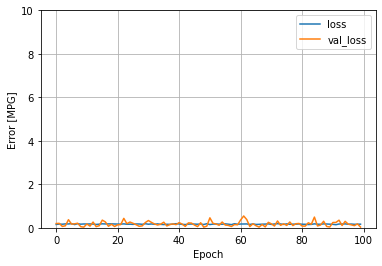

In [393]:
plot_loss(history)

In [402]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(24, activation='relu'),
      keras.layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [403]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 32)                65        
_________________________________________________________________
dense_41 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_42 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 25        
Total params: 3,762
Trainable params: 3,697
Non-trainable params: 65
_________________________________________________________________


In [405]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.4,
    verbose=1, epochs=100
    ,batch_size=80)

Epoch 1/100
262/262 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0279
Epoch 2/100
262/262 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0278
Epoch 3/100
262/262 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0280
Epoch 4/100
262/262 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0278
Epoch 5/100
262/262 [==============================] - 1s 2ms/step - loss: 0.0274 - val_loss: 0.0279
Epoch 6/100
262/262 [==============================] - 1s 2ms/step - loss: 0.0274 - val_loss: 0.0278
Epoch 7/100
262/262 [==============================] - 1s 2ms/step - loss: 0.0274 - val_loss: 0.0279
Epoch 8/100
262/262 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0278
Epoch 9/100
262/262 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0281
Epoch 10/100
262/262 [==============================] - 0s 2ms/step - loss: 0.0274 - val_lo

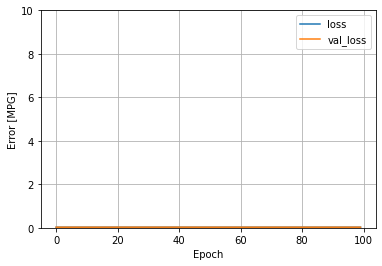

In [406]:
plot_loss(history)

In [400]:
x = tf.linspace(0.0, 250, 251)
y = dnn_model.predict(x)

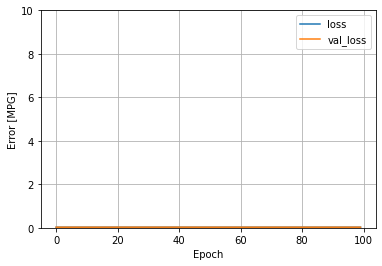

In [408]:
plot_loss(history)

In [410]:
# instanciate the models
#tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(max_iter = 1000)
randomForest = RandomForestClassifier(n_estimators = 700)
boostedTree  = GradientBoostingClassifier()
#svm          = SVC(gamma = "scale", probability = True)
#neuralNet    = MLPClassifier()
#neighbors    = KNeighborsClassifier()

In [411]:
# create a dict to loop through the models later on
models = {
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
         }

In [412]:
# fit the models
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")

logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully


In [415]:
# AUC

performances = {}

for model in models:
    predictions   = models[model].predict(X_train)
    probabilities = pd.DataFrame(models[model].predict_proba(X_train))[1]
    accuracy      = accuracy_score(y_train,predictions)
    auc           = roc_auc_score(np.array(y_train),np.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [416]:
pd.DataFrame(performances)

,logistic,randomForest,boostedTree
Accuracy,0.972569,1.0,0.973573
AUC,0.604755,1.0,0.785413


1091/1091 [==============================] - 1s 834us/step - loss: 0.1257 - accuracy: 0.9726
97.25693464279175


Text(69.0, 0.5, 'Truth')

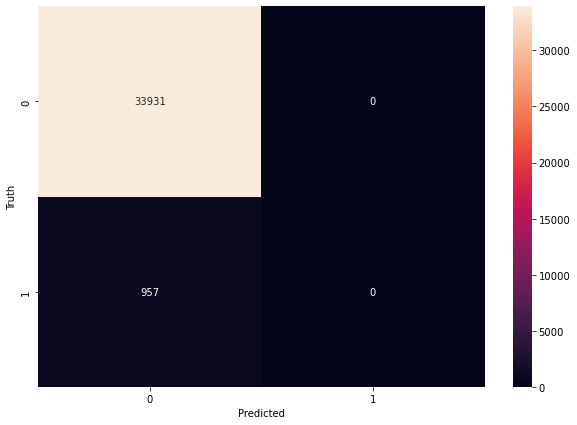

In [360]:
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sn

#Evaluate model
scores = model.evaluate(X_train, y_train)
print(scores[1]*100)

yp = model.predict(X_train)

y_pred = []
for element in yp:
    if element > 0.32:
        y_pred.append(1)
    else:
        y_pred.append(0)

#print(classification_report(X_train,y_train))

cm = tf.math.confusion_matrix(labels=y_train,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [251]:
#ann_test_pred = model.predict(X_test)
ann_7244_pred = model.predict(X_7244)

In [260]:
ann_7244_pred.ravel()

array([0.02741548, 0.02741548, 0.02741548, ..., 0.02741548, 0.02741548,
       0.02741548], dtype=float32)

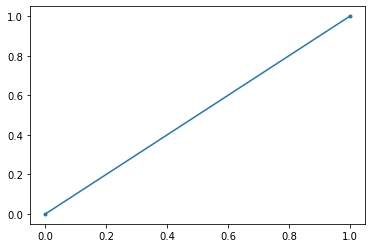

In [269]:
from sklearn.metrics import roc_curve, auc


y_pred = model.predict(X_7244).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_7244, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)


In [151]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_7244,  model.predict(X_7244).ravel())

#Plot ROC AUC Curve 
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [ ]:
from keras.models import model_from_json
from tensorflow.keras.models import load_model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")